In [1]:
import os
import json
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Using TensorFlow backend.


In [2]:
path_to_train_data = '/home/harshal/Documents/Projects/Deep Learning for Vision/Image_data/finaltrain'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, validation_split=0.2)

#test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(path_to_train_data,
                                                 target_size = (32, 32),
                                                 batch_size = 128,
                                                 class_mode ='categorical', subset='training')
validation_set = train_datagen.flow_from_directory(path_to_train_data,
                                                 target_size = (32, 32),
                                                 batch_size = 128,
                                                 class_mode ='categorical', subset='validation')

Found 22572 images belonging to 75 classes.
Found 5601 images belonging to 75 classes.


In [4]:
from keras.callbacks.callbacks import BaseLogger
class TrainingMonitor(BaseLogger):
    def __init__(self, figPath, jsonPath=None, startAt=0):
        # store the output path for the figure, the path to the JSON
        # serialized file, and the starting epoch
        super(TrainingMonitor, self).__init__()
        self.figPath = figPath
        self.jsonPath = jsonPath
        self.startAt = startAt

    def on_train_begin(self, logs={}):
        # initialize the history dictionary
        self.H = {}

        # if the JSON history path exists, load the training history
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.H = json.loads(open(self.jsonPath).read())

                # check to see if a starting epoch was supplied
                if self.startAt > 0:
                    # loop over the entries in the history log and
                    # trim any entries that are past the starting
                    # epoch
                    for k in self.H.keys():
                        self.H[k] = self.H[k][:self.startAt]

    def on_epoch_end(self, epoch, logs={}):
        # loop over the logs and update the loss, accuracy, etc.
        # for the entire training process
        for (k, v) in logs.items():
            l = self.H.get(k, [])
            l.append(v)
            self.H[k] = l

        # check to see if the training history should be serialized
        # to file
        if self.jsonPath is not None:
            f = open(self.jsonPath, "w")
            f.write(json.dumps(str(self.H)))
            f.close()

        # ensure at least two epochs have passed before plotting
        # (epoch starts at zero)
        if len(self.H["loss"]) > 1:
            # plot the training loss and accuracy
            N = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(N, self.H["loss"], label="train_loss")
            plt.plot(N, self.H["val_loss"], label="val_loss")
            plt.plot(N, self.H["accuracy"], label="train_acc")
            plt.plot(N, self.H["val_accuracy"], label="val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(
                len(self.H["loss"])))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()

            # save the figure
            plt.savefig(self.figPath)
            plt.close()

In [5]:
classifier = Sequential()
classifier.add(Conv2D(64, (3, 3), padding='same', input_shape = (32, 32, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(BatchNormalization())
classifier.add(Conv2D(64, (3, 3),padding='same',  activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size =2, strides=2))
classifier.add(Flatten())
classifier.add(Dense(1024, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 75, activation = 'softmax'))
classifier.summary()
classifier.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
#Adding Checkpoint and early stopping callbacks
figPath = os.path.sep.join([r'/home/harshal/Documents/Projects/Deep Learning for Vision/output_2', "{}.png".format(os.getpid())])
jsonPath = os.path.sep.join([r'/home/harshal/Documents/Projects/Deep Learning for Vision/output_2', "{}.json".format(os.getpid()+1)])
path_checkpoint = 'hack_checkpoint_2.keras'
callback_checkpoint=keras.callbacks.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
callback_early_stopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callback_reduce_lr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-5, patience=0, verbose=1)
callbacks= [TrainingMonitor(figPath, jsonPath=jsonPath), callback_early_stopping, callback_checkpoint, callback_reduce_lr]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)        

In [6]:
classifier.fit_generator(training_set, validation_data =validation_set, epochs = 25, callbacks=callbacks)

Epoch 1/25
177/177 [==============================] - 145s 819ms/step - loss: 1.2477 - accuracy: 0.6883 - val_loss: 5.6113 - val_accuracy: 0.1200

Epoch 00001: val_loss improved from inf to 5.61129, saving model to hack_checkpoint_2.keras
Epoch 2/25
177/177 [==============================] - 148s 836ms/step - loss: 0.5352 - accuracy: 0.8453 - val_loss: 3.9892 - val_accuracy: 0.1764

Epoch 00002: val_loss improved from 5.61129 to 3.98917, saving model to hack_checkpoint_2.keras
Epoch 3/25
177/177 [==============================] - 172s 973ms/step - loss: 0.3791 - accuracy: 0.8834 - val_loss: 3.1131 - val_accuracy: 0.3374

Epoch 00003: val_loss improved from 3.98917 to 3.11314, saving model to hack_checkpoint_2.keras
Epoch 4/25
177/177 [==============================] - 202s 1s/step - loss: 0.2963 - accuracy: 0.9073 - val_loss: 1.4788 - val_accuracy: 0.6999

Epoch 00004: val_loss improved from 3.11314 to 1.47880, saving model to hack_checkpoint_2.keras
Epoch 5/25
177/177 [===============

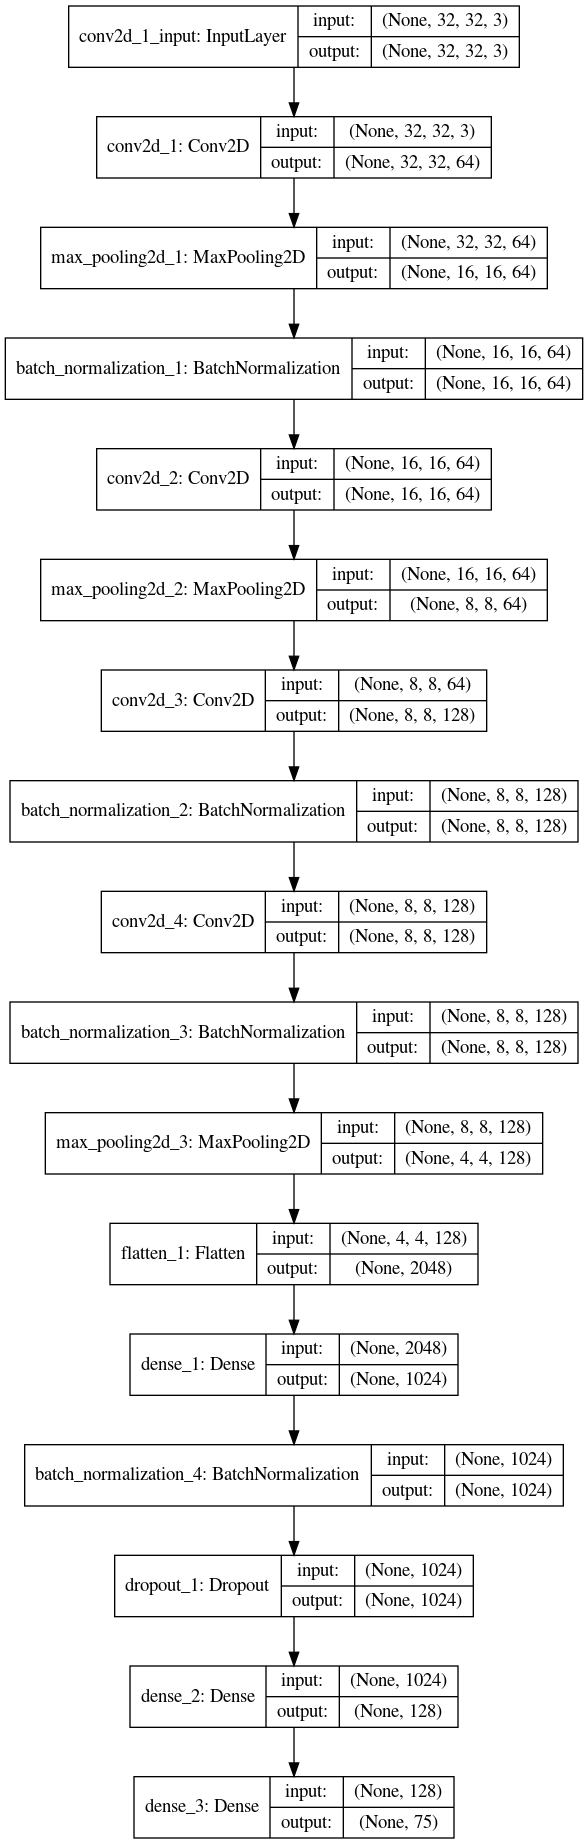

In [9]:
from keras.utils import plot_model
plot_model(classifier, to_file='model_arch.png', show_shapes=True)

In [10]:
classifier.save('final_model.h5')